In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# 1.a Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

training_data.data.shape, testing_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [4]:
# 1.b DataLoader
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, 64, shuffle=True)
testing_dataloader = DataLoader(testing_data, 64, shuffle=False)

X, y = next(iter(training_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [5]:
cuda_X, cuda_y = X.to(device), y.to(device)

In [6]:
# play with conv layer
from torch import nn

# build a conv layer with basic parameter
# n input channel, n output feature, ks:kenel size, act:activate
def conv(ni, nf, ks=3, stride=1, act=True):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    res = nn.Sequential(*layers)
    return res

def block(ni, nf): return conv(ni, nf)

# get model from block
def get_model():
    return nn.Sequential(
            block(1,16),   #14x14
            block(16,32),  #7x7
            block(32, 64), #4x4
            block(64, 128),#2x2
            block(128,256),#1x1
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 10)).to(device)

In [7]:
# Learning rate finder:
import matplotlib.pyplot as plt

def learning_rate_finder(model, dataloader, opt=None, cut_off=3):
    lr = 1e-6
    lrs = []
    losses = []
    optimizer = opt(model.parameters(), lr=lr)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # update lr
        optimizer.param_groups[0]['lr'] *= 1.1
        if optimizer.param_groups[0]['lr'] > 1: break
    plt.xscale('log')
    plt.plot(lrs[0:-cut_off], losses[0:-cut_off])
    plt.show()

In [8]:
# 5. Combine things together:
# train model
def train(model, dataloader, opt=None, epochs=2):
    size = len(dataloader.dataset)
    for epoch in range(epochs):
        print(epoch)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # backward
            loss.backward()
            opt.step()
            opt.zero_grad()

            if batch % 300 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# learning_rate_finder(model, training_dataloader)
# optimizer = SGD(model.parameters(), lr=1e-2)
# train(model, training_dataloader, optimizer)

In [9]:
def test(model, testing_dataloader):
    size = len(testing_dataloader.dataset)
    total = 0
    for X, y in testing_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        total += sum(y_hat.argmax(1) == y).item()
    print(f'Accuracy: {total/size:>2f}')
    
# test(model, testing_dataloader)

In [10]:
from IPython.core.debugger import set_trace

def noop(x):
    return x

# ResnetBlock
class ResnetBlock(nn.Module):
    def __init__(self, ni, nf, stride=2):
        super(ResnetBlock, self).__init__()
        self.convs = nn.Sequential(
                        conv(ni, nf),
                        conv(nf, nf, stride=stride, act=False))
        self.pool = noop if stride == 1 else nn.AvgPool2d(stride, ceil_mode=True)
        self.idconv = noop if ni == nf else conv(ni, nf, ks=1, act=False)
    def forward(self, x):
        return nn.ReLU()(self.convs(x) + self.idconv(self.pool(x)))

In [11]:
# Resnet block
def block(ni, nf): return ResnetBlock(ni, nf)
# model = get_model()
# learning_rate_finder(model, training_dataloader) # 1e-3
# optimizer = SGD(model.parameters(), lr=1e-3)
# train(model, training_dataloader, optimizer, 3)
# test(model, testing_dataloader)
# 0.893100

In [30]:
class RMSPropOptimizer():
    def __init__(self, params, lr, mom=0.99):
        self.params = list(params)
        self.param_groups = [{}]
        self.param_groups[0]['lr'] = lr
        self.mom = mom
        self.square_avg = {}
        self.eps = 1e-7
    def zero_grad(self):
        for p in self.params:
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p in self.params:
            # get avg_grad:
            square_avg = self.square_avg[p] if p in self.square_avg else torch.zeros_like(p)
            # update avg_grad:
            square_avg = square_avg * self.mom + p.grad.data**2
            self.square_avg[p] = square_avg
            # step
            p.data -= self.param_groups[0]['lr'] * (p.grad.data / torch.sqrt(square_avg + self.eps))

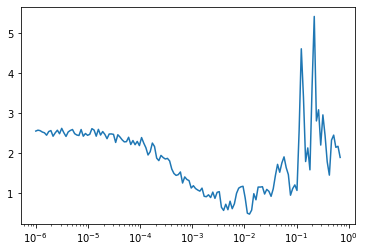

In [31]:
# Train model:
model = get_model()
loss_fn = nn.CrossEntropyLoss()
learning_rate_finder(model, training_dataloader, opt=RMSPropOptimizer) # 3e-3

In [ ]:
model = get_model()
optimizer = RMSPropOptimizer(model.parameters(), lr=1e-4)
train(model, training_dataloader, optimizer, 3)
test(model, testing_dataloader)

0
loss: 2.489247  [    0/60000]
loss: 0.804315  [19200/60000]
loss: 0.470590  [38400/60000]
loss: 0.400366  [57600/60000]
1
loss: 0.532622  [    0/60000]
loss: 0.463096  [19200/60000]
loss: 0.412486  [38400/60000]
loss: 0.547243  [57600/60000]
2
loss: 0.243127  [    0/60000]
loss: 0.418845  [19200/60000]
loss: 0.147247  [38400/60000]
loss: 0.416730  [57600/60000]
